<a href="https://colab.research.google.com/github/AlbertPangilinan/SEP740/blob/main/%E2%80%9Cvgg_rf_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib. pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#Dataset pre-processing

###creating image loading function, image resizing function and image dividing function

In [2]:
input_paths = '/content/drive/MyDrive/archive/dataset/semantic_drone_dataset/original_images'
output_paths = '/content/drive/MyDrive/archive/RGB_color_image_masks/RGB_color_image_masks'
sematic_paths = '/content/drive/MyDrive/archive/dataset/semantic_drone_dataset/label_images_semantic'

images_paths = os.listdir(input_paths)
labels_paths = os.listdir(output_paths)
sLabels_paths = os.listdir(sematic_paths)

images_paths.sort()
labels_paths.sort()
sLabels_paths.sort()

images_list = [os.path.join(input_paths,i) for i in images_paths]
labels_list = [os.path.join(output_paths,i) for i in labels_paths]
sLabels_list = [os.path.join(sematic_paths,i) for i in sLabels_paths]

In [3]:
images_names  = tf.constant(images_list)
labels_names = tf.constant(labels_list)
sLabels_names = tf.constant(sLabels_list)

dataset = tf.data.Dataset.from_tensor_slices((images_names,labels_names,sLabels_names))

In [4]:
#Load images and labels
def load_img_lab(img_path, lab_path, slab_path):
    images = tf.io.read_file(img_path)
    #print(images)
    #print(type(images))
    images = tf.image.decode_png(images)
    #print('images shape is: ', images.shape)
    images = tf.image.convert_image_dtype(images,tf.float32)
    #print('images after is: ', np.array(images))

    labels = tf.io.read_file(lab_path)
    labels = tf.image.decode_png(labels)
    labels = tf.image.convert_image_dtype(labels,tf.float32)
    
    semantics = tf.io.read_file(slab_path)
    semantics = tf.image.decode_png(semantics)
    semantics =  tf.image.convert_image_dtype(semantics,tf.float32)

    return images, labels, semantics

#Resize iamges and labels
def resize(image, label, sLabel):
    input_images = tf.image.resize(image,(80,120),method='nearest')
    input_labels = tf.image.resize(label,(80,120),method='nearest')
    input_semantics = tf.image.resize(sLabel,(80,120),method='nearest')

    return input_images,input_labels,input_semantics

In [5]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
def divide_image(image, label, sem, tile_height=40, tile_width=60):
  # RGB images
  image_channels = 3
  label_channels = 3

  image_height, image_width  = np.array(image.shape)[0:2]
  label_height, label_width = np.array(label.shape)[0:2]
  sem_height, sem_width, = np.array(sem.shape)[0:2]

  img_arr = image.reshape(image_height // tile_height,
                              tile_height,
                              image_width // tile_width,
                              tile_width,
                              image_channels)

  img_arr = tf.transpose(img_arr, [0,2,1,3,4])
  num_tiles = (image_height // tile_height) * (image_width // tile_width)
  img_arr = img_arr.reshape(num_tiles, tile_height, tile_width, image_channels)


  lab_arr = label.reshape(label_height // tile_height,
                              tile_height,
                              label_width // tile_width,
                              tile_width,
                              label_channels)

  lab_arr = tf.transpose(lab_arr, [0,2,1,3,4])
  num_tiles = (label_height // tile_height) * (label_width // tile_width)
  lab_arr = lab_arr.reshape(num_tiles, tile_height, tile_width, label_channels)


  sem_arr = sem.reshape(sem_height // tile_height,
                              tile_height,
                              sem_width // tile_width,
                              tile_width, 1)

  sem_arr = tf.transpose(sem_arr, [0,2,1,3,4])
  num_tiles = (sem_height // tile_height) * (sem_width // tile_width)
  sem_arr = sem_arr.reshape(num_tiles, tile_height, tile_width, 1)

  return img_arr, lab_arr, sem_arr

In [6]:
import PIL
from PIL import Image

# loading the image
img = PIL.Image.open(images_list[0])

# fetching the dimensions
wid, hgt = img.size

# displaying the dimensions
print(str(wid) + "x" + str(hgt))

6000x4000


###Visulize sample images after resizing images

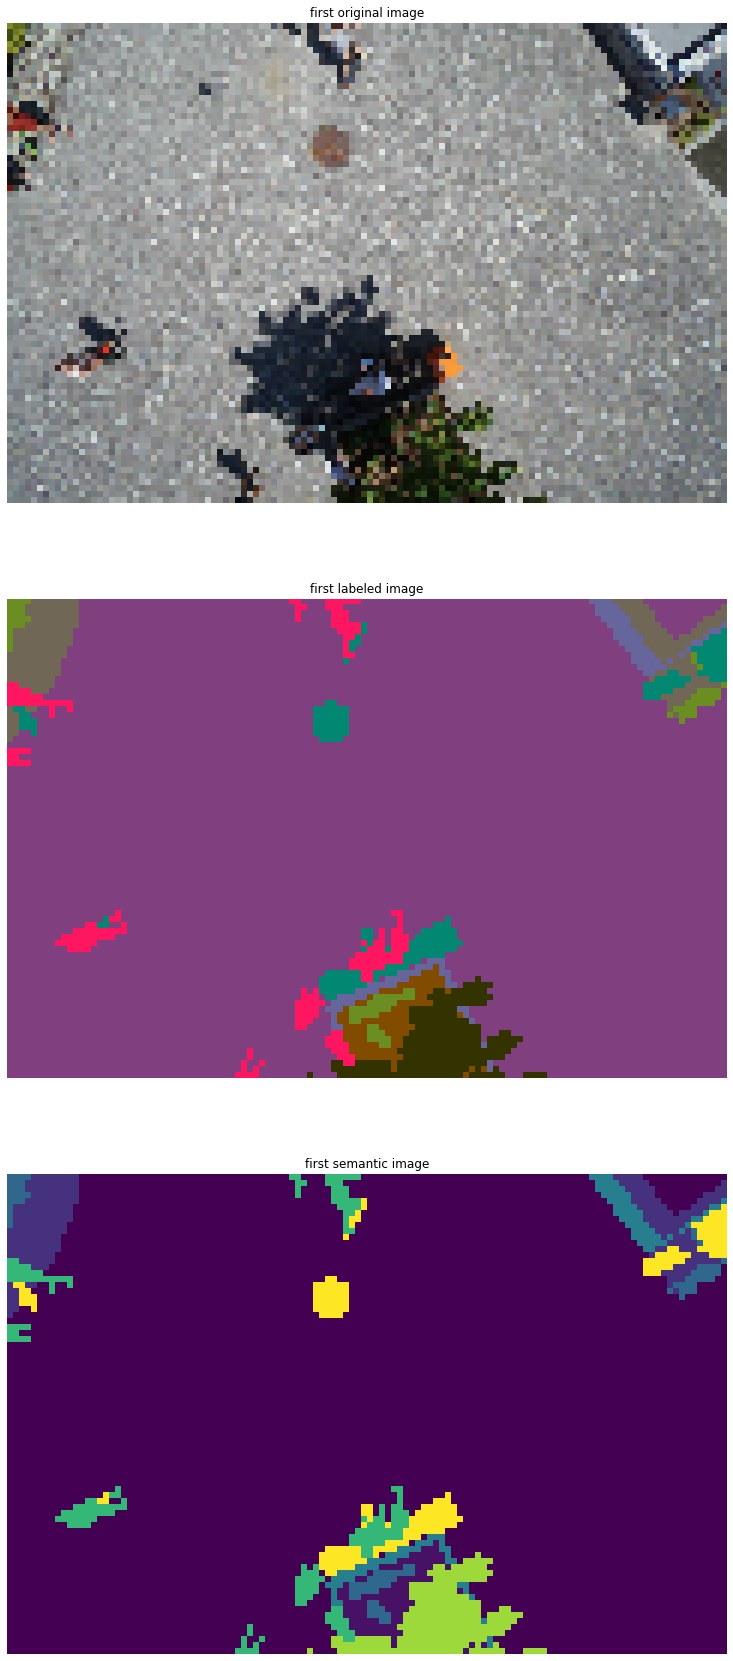

In [7]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
imgs_labs = dataset.map(load_img_lab)
resized_imgs_labs = imgs_labs.map(resize)
divided_imgs_labs = resized_imgs_labs.map(divide_image)
#for i, l, s in resized_imgs_labs.take(1):
#  print('s has dimension: ',s.shape)
for img, lab, sem in resized_imgs_labs.take(1):
    _, axis = plt.subplots(3,1,figsize=(30,30))
    axis[0].set_title('first original image')
    axis[0].imshow(tf.keras.preprocessing.image.array_to_img(img))
    axis[0].axis('off')
    axis[1].set_title('first labeled image')
    axis[1].imshow(tf.keras.preprocessing.image.array_to_img(lab))
    axis[1].axis('off')
    axis[2].set_title('first semantic image')
    axis[2].imshow(tf.keras.preprocessing.image.array_to_img(sem))
    axis[2].axis('off')

#Visulize sample images after resizing and dividing images

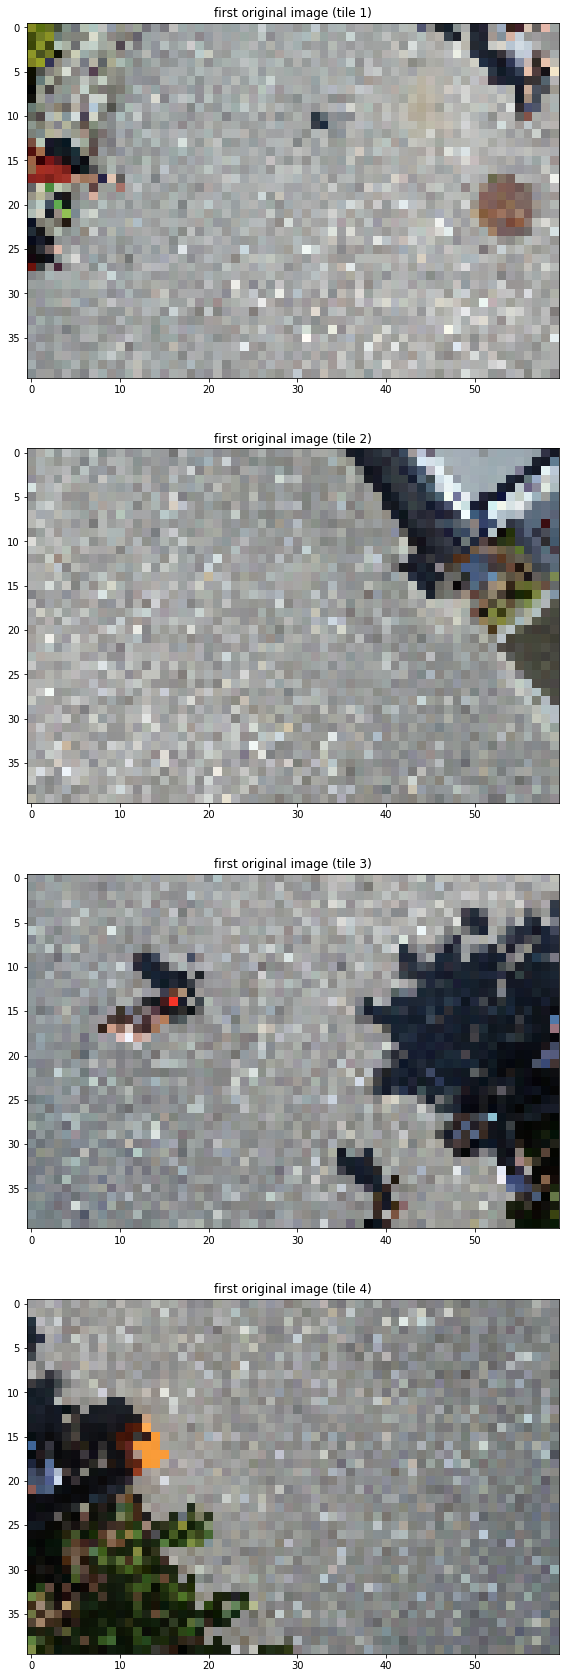

In [8]:
p=0
q=0
h=0
_, axis = plt.subplots(4,1,figsize=(30,30))
for i,j,k in divided_imgs_labs.take(1):
  for x in i:
    axis[p].set_title('first original image (tile {})'.format(p+1))
    axis[p].imshow(tf.keras.preprocessing.image.array_to_img(x))
    p=p+1

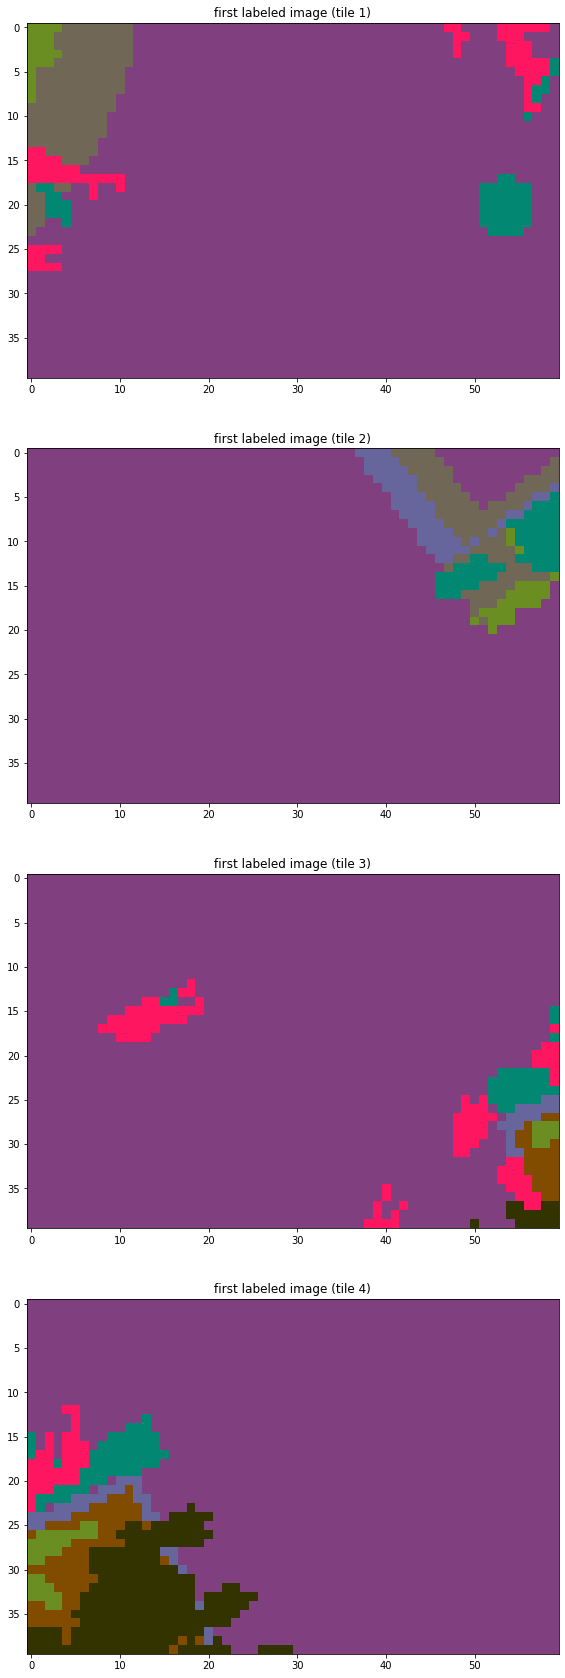

In [9]:
_, axis = plt.subplots(4,1,figsize=(30,30))
for i,j,k in divided_imgs_labs.take(1):
  for x in j:
    axis[q].set_title('first labeled image (tile {})'.format(q+1))
    axis[q].imshow(np.array(x))
    q=q+1

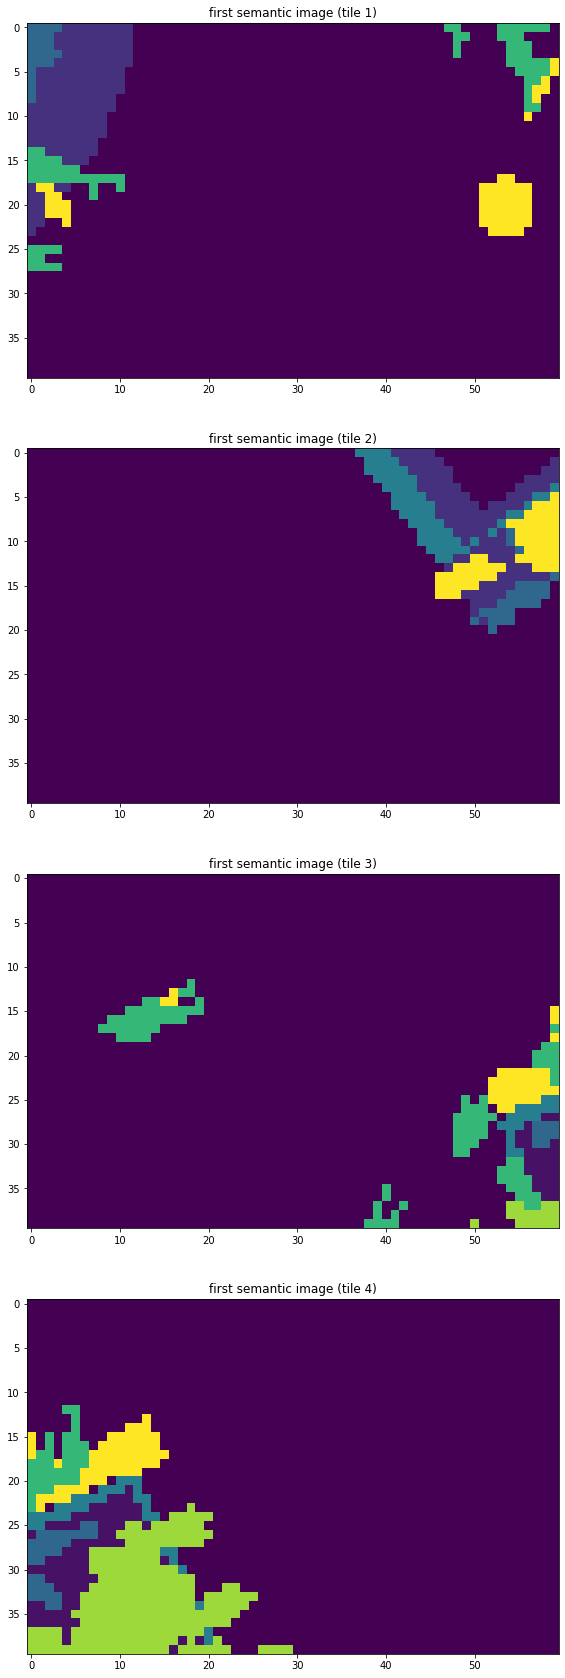

In [10]:
_, axis = plt.subplots(4,1,figsize=(30,30))
for i,j,k in divided_imgs_labs.take(1):
  for x in k:
    axis[h].set_title('first semantic image (tile {})'.format(h+1))
    axis[h].imshow(tf.keras.preprocessing.image.array_to_img(x))
    h=h+1

#Model building

In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle

from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16

In [12]:
#y_train = np.expand_dims(y_train, axis=3) #May not be necessary.. leftover from previous code 
#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(40, 60, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 60, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 40, 60, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 40, 60, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 20, 30, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 20, 30, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 20, 30, 128)       147584    
                                                              

In [13]:
#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 60, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 40, 60, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 40, 60, 64)        36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [14]:
import cv2

train_images = []
train_masks = []

for img, lab, sem in divided_imgs_labs.take(400):
  for x in img:
    train_images.append(np.array(x))
  for l in sem:
    train_masks.append(np.array(l))

In [19]:
X_train = np.array(train_images)
y_train = np.array(train_masks)

In [20]:
#Now, let us apply feature extractor to our training data
features=new_model.predict(X_train)

50/50 [==============================] - 6s 3ms/step


###Visualize sample features extracted by VGG16

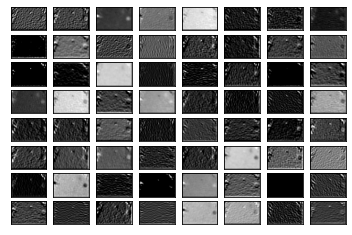

In [22]:
#Plot features to view them
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray',aspect='auto')
        ix +=1
plt.show()

In [23]:
#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

#Reshape Y to match X
Y = y_train.reshape(-1)

#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels. 
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

[0.03137255 0.01568628 0.00392157 0.05882353 0.08627451 0.03921569
 0.00784314 0.07450981 0.0509804  0.08235294 0.05490196 0.01176471
 0.         0.03529412 0.04313726 0.04705883 0.07843138 0.07058824
 0.06666667 0.02352941 0.01960784 0.0627451  0.02745098]
0.003922    1450580
0.011765     768433
0.035294     283569
0.015686     280917
0.031373     273543
0.086275     136396
0.007843     123085
0.039216     103520
0.019608      85228
0.074510      79041
0.078431      51320
0.058824      40402
0.050980      36875
0.066667      30269
0.023529      27665
0.027451      24600
0.043137      21546
0.082353       8762
0.070588       8328
0.000000       2101
0.054902       2053
0.047059       1219
0.062745        548
Name: Label, dtype: int64


In [24]:
##If we do not want to include pixels with value 0 
##e.g. Sometimes unlabeled pixels may be given a value 0.
dataset = dataset[dataset['Label'] != 0]
from sklearn import preprocessing
#Redefine X and Y for Random Forest
X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']
Y_for_RF = preprocessing.LabelEncoder().fit_transform(Y_for_RF)

X_train, X_test, y_train, y_test = train_test_split(X_for_RF, Y_for_RF, test_size=0.3, random_state=20)

print(X_train)
print(y_train)

               0         1         2         3          4         5   \
3274299  2.281869  2.094916  0.776188  5.755965  10.022154  0.569553   
2901424  2.356979  2.350586  1.567105  2.510037  11.714908  5.364663   
2847583  3.570601  1.743677  1.519425  2.417167  10.948382  2.712308   
384231   0.672202  0.882477  2.443916  3.806894  11.850044  1.828973   
642403   2.531949  0.359749  1.393766  2.274156   9.808640  4.196772   
...           ...       ...       ...       ...        ...       ...   
556691   0.383711  0.316870  1.458796  2.841910  11.625279  0.331496   
1335389  1.135823  1.140513  1.252240  2.427902  12.689172  0.315887   
1086559  2.233618  1.541381  1.438635  2.385887  11.815683  0.915165   
2977915  1.271081  1.804672  0.956806  3.450113   8.759782  0.554447   
1032309  1.221319  1.252025  1.543439  2.600768  12.779326  0.416032   

               6         7         8         9   ...   54        55        56  \
3274299  0.812584  2.891928  0.000000  1.844541  ...  

In [25]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 5, criterion='gini', min_samples_split =2, max_features = 'sqrt', random_state = 15)

# Train the model on training data
model.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=5, random_state=15)

####Estimate accuracy with the model built

In [26]:
prediction_test = model.predict(X_test)
#print(y_test, prediction_test)

from sklearn import metrics
#Print the prediction accuracy
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))

Accuracy =  0.6635034784647854


###Visualize sample prediction outcomes

1/1 [==============================] - 0s 15ms/step


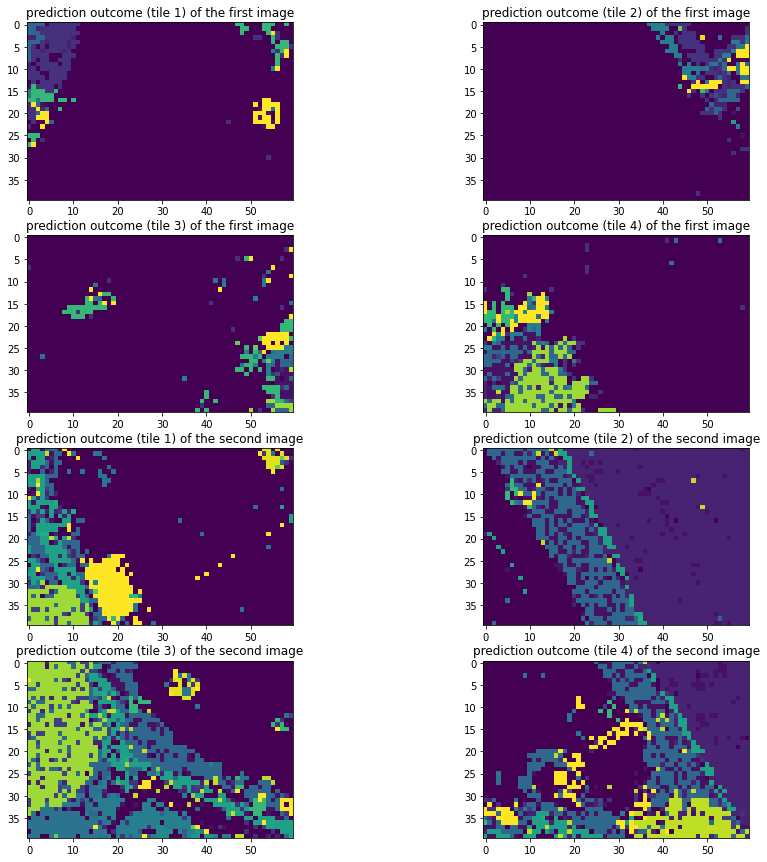

In [124]:
outcome_vgg = new_model.predict(np.array(train_images)[0:8])
outcome_vgg = outcome_vgg.reshape(-1, outcome_vgg.shape[3])
outcome_rf = model.predict(outcome_vgg)
final = outcome_rf.reshape(8, 40, 60)

_, axes = plt.subplots(4,2,figsize=(15,15))
k = 0
for i in range(4):
  for j in range(2):
    if k<=3:
      axes[i][j].set_title('prediction outcome (tile {}) of the first image'.format(k+1))
      axes[i][j].imshow(final[k])
    else:
      axes[i][j].set_title('prediction outcome (tile {}) of the second image'.format(k-3))
      axes[i][j].imshow(final[k])
    k+=1

#Fine Tuning

In [27]:
def create_vgg16_rf_model(n_estimators = 5, criterion='gini', min_samples_split =2, max_features = 'sqrt', random_state = 15):
  model = RandomForestClassifier(n_estimators = 5, criterion='gini', min_samples_split =2, max_features = 'sqrt', random_state = 15)
  return model

In [28]:
# create 
from keras.wrappers.scikit_learn import KerasClassifier
model_1 = KerasClassifier(build_fn=create_vgg16_rf_model, verbose=1)
# define parameters and values for grid search 
param_grid = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_features':['sqrt', 'log2']
}

#grid = GridSearchCV(estimator=model_1, param_grid=param_grid, cv=5)
#grid_result = grid.fit(X_train, y_train)

# summarize results
#display_cv_results(grid_result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
# Build the grid search
from sklearn.model_selection import GridSearchCV
dfrst = create_vgg16_rf_model()
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
grid_results = grid.fit(X_train, y_train)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)
results_df

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/para

Best: [0.65961841 0.65704037 0.66104702 0.65894245        nan        nan], using {'criterion': 'entropy', 'max_features': 'sqrt'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,271.739839,2.586638,2.377662,0.036319,gini,sqrt,"{'criterion': 'gini', 'max_features': 'sqrt'}",0.660449,0.659291,0.659112,0.659879,0.659361,0.659618,0.000487,2
1,198.532096,2.485130,2.389181,0.065574,gini,log2,"{'criterion': 'gini', 'max_features': 'log2'}",0.658290,0.656412,0.656810,0.656827,0.656863,0.657040,0.000646,4
2,800.928873,4.604108,2.138471,0.040903,entropy,sqrt,"{'criterion': 'entropy', 'max_features': 'sqrt'}",0.662386,0.661109,0.660975,0.660558,0.660206,0.661047,0.000741,1
3,601.573789,6.226072,2.127461,0.072373,entropy,log2,"{'criterion': 'entropy', 'max_features': 'log2'}",0.659935,0.658260,0.659520,0.658554,0.658444,0.658942,0.000661,3
4,0.833077,0.022947,0.000000,0.000000,log_loss,sqrt,"{'criterion': 'log_loss', 'max_features': 'sqrt'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
5,0.811984,0.011099,0.000000,0.000000,log_loss,log2,"{'criterion': 'log_loss', 'max_features': 'log2'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


In [30]:
def display_cv_results(search_results):
    print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_))
    means = search_results.cv_results_['mean_test_score']
    stds = search_results.cv_results_['std_test_score']
    params = search_results.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param))

In [31]:
display_cv_results(grid_results)

Best score = 0.6610 using {'criterion': 'entropy', 'max_features': 'sqrt'}
mean test accuracy +/- std = 0.6596 +/- 0.0005 with: {'criterion': 'gini', 'max_features': 'sqrt'}
mean test accuracy +/- std = 0.6570 +/- 0.0006 with: {'criterion': 'gini', 'max_features': 'log2'}
mean test accuracy +/- std = 0.6610 +/- 0.0007 with: {'criterion': 'entropy', 'max_features': 'sqrt'}
mean test accuracy +/- std = 0.6589 +/- 0.0007 with: {'criterion': 'entropy', 'max_features': 'log2'}
mean test accuracy +/- std = nan +/- nan with: {'criterion': 'log_loss', 'max_features': 'sqrt'}
mean test accuracy +/- std = nan +/- nan with: {'criterion': 'log_loss', 'max_features': 'log2'}


###Estimate accuracy with the model modified based on the result of fine tuning

In [79]:
model2 = RandomForestClassifier(n_estimators = 5, criterion='entropy', min_samples_split =2, max_features = 'sqrt', random_state = 15)
model2.fit(X_train, y_train)
prediction_test2 = model2.predict(X_test)
#print(y_test, prediction_test)

from sklearn import metrics
#Print the prediction accuracy
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test2))

Accuracy =  0.6653986120882079


###Visualize sample prediction outcomes after fine tuning

1/1 [==============================] - 0s 15ms/step


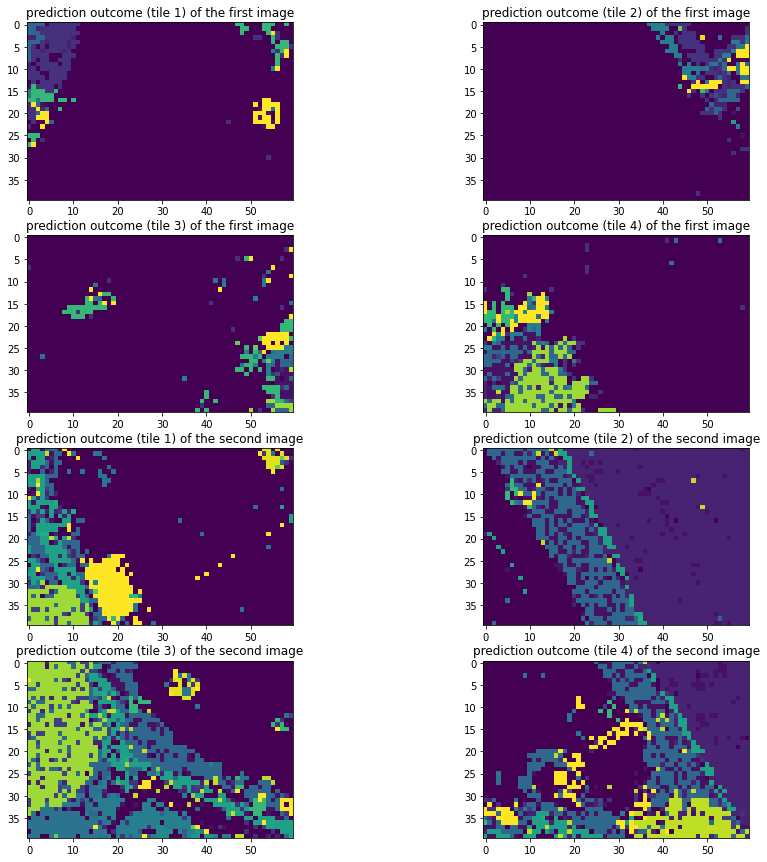

In [125]:
tuning_model = RandomForestClassifier(n_estimators = 5, criterion='entropy', min_samples_split =2, max_features = 'sqrt', random_state = 15)
outcome_vgg = new_model.predict(np.array(train_images)[0:8])
outcome_vgg = outcome_vgg.reshape(-1, outcome_vgg.shape[3])
outcome_rf = model.predict(outcome_vgg)
final = outcome_rf.reshape(8, 40, 60)
_, cor = plt.subplots(4,2,figsize=(15,15))
k = 0
for i in range(4):
  for j in range(2):
    if k<=3:
      cor[i][j].set_title('prediction outcome (tile {}) of the first image'.format(k+1))
      cor[i][j].imshow(final[k])
    else:
      cor[i][j].set_title('prediction outcome (tile {}) of the second image'.format(k-3))
      cor[i][j].imshow(final[k])
    k+=1